In [ ]:
%load_ext autoreload
%autoreload 2

import ipywidgets as w
w.Widget.close_all()

from rotating_coil_analyzer.gui.app import build_catalog_gui
gui = build_catalog_gui()
gui



In [3]:
import os
import re

from rotating_coil_analyzer.ingest.readers_sm18 import Sm18CorrSigsReader

# 1) Point to the exact file you are debugging (example: Seg3)
fpath = r"C:\Local data\2025_12_SM18test\HCMCBRD_S001-CR000012_20240315_093813_AP1-0_AP2-Stair_Step\aperture1\HCMCBRD_S001-CR000012_20240315_093813_AP1-0_AP2-Stair_Step_corr_sigs_Ap_1_Seg3.bin"

# 2) Run id (usually the prefix of your file/folder; keep consistent)
run_id = "HCMCBRD_S001-CR000012_20240315_093813_AP1-0_AP2-Stair_Step"

# 3) Segment from filename (fallback to "3" if parsing fails)
m = re.search(r"_Seg(\d+)\.bin$", os.path.basename(fpath))
segment = m.group(1) if m else "3"

# 4) Acquisition settings (from Parameters.txt)
Ns = 512
shaft_speed_rpm = 60.0  # use abs(v); sign doesn't matter for period

reader = Sm18CorrSigsReader()
seg_frame = reader.read(
    fpath,
    run_id=run_id,
    segment=segment,
    samples_per_turn=Ns,
    shaft_speed_rpm=shaft_speed_rpm,
)

seg_frame, seg_frame.df.head()


C:\Users\albellel\python-projects\rotating-coil-analyzer\rotating_coil_analyzer\ingest\readers_sm18.py:175: RuntimeWarning: invalid value encountered in cast
  mat = arr.reshape(-1, ncols).astype(np.float64, copy=False)


(SegmentFrame(source_path=WindowsPath('C:/Local data/2025_12_SM18test/HCMCBRD_S001-CR000012_20240315_093813_AP1-0_AP2-Stair_Step/aperture1/HCMCBRD_S001-CR000012_20240315_093813_AP1-0_AP2-Stair_Step_corr_sigs_Ap_1_Seg3.bin'), run_id='HCMCBRD_S001-CR000012_20240315_093813_AP1-0_AP2-Stair_Step', segment='3', samples_per_turn=512, n_turns=3901, df=                   t    df_abs        df_cmp         I        I0        I1  \
 0           0.001966  0.000004 -1.307197e-06  0.018206 -0.001068  0.018206   
 1           0.003913  0.000004 -1.377775e-06  0.017548 -0.001323  0.017548   
 2           0.005872  0.000004 -1.498101e-06  0.016886 -0.001579  0.016886   
 3           0.007817  0.000004 -1.596276e-06  0.016229 -0.001833  0.016229   
 4           0.009759  0.000004 -1.684258e-06  0.015573 -0.002087  0.015573   
 ...              ...       ...           ...       ...       ...       ...   
 1997307  3944.029655 -0.000004  8.095059e-07  0.001038 -0.014579  0.001038   
 1997308  3944.031643 -

In [4]:
import numpy as np

df = seg_frame.df
Ns = seg_frame.samples_per_turn
n_turns = len(df) // Ns
sl = slice(0, n_turns*Ns)

abs_mat = df["df_abs"].to_numpy()[sl].reshape(n_turns, Ns)
abs_rms = np.sqrt(np.mean(abs_mat**2, axis=1))  # per-turn amplitude proxy

cand = [c for c in ["I", "I0", "I1", "I2"] if c in df.columns]
print("candidates:", cand)

for c in cand:
    x = df[c].to_numpy()[sl].reshape(n_turns, Ns)
    per_turn_med = np.median(x, axis=1)
    within_turn_std_med = float(np.median(np.std(x, axis=1)))

    corr = np.corrcoef(per_turn_med, abs_rms)[0, 1]
    p05, p995 = np.percentile(per_turn_med, [0.5, 99.5])

    print(f"{c:>3s}  within-turn std~{within_turn_std_med:.4g}   "
          f"turn-med range(p99.5-p0.5)~{(p995-p05):.4g}   corr(abs_rms)={corr:.3f}")


candidates: ['I', 'I0', 'I1', 'I2']
  I  within-turn std~0.01281   turn-med range(p99.5-p0.5)~786   corr(abs_rms)=-0.000
 I0  within-turn std~0.01086   turn-med range(p99.5-p0.5)~0.01241   corr(abs_rms)=-0.011
 I1  within-turn std~0.01281   turn-med range(p99.5-p0.5)~786   corr(abs_rms)=-0.000
 I2  within-turn std~0.01281   turn-med range(p99.5-p0.5)~786   corr(abs_rms)=-0.000


In [5]:
import numpy as np

sl = slice(0, (len(seg_frame.df)//seg_frame.samples_per_turn)*seg_frame.samples_per_turn)
for c in ["I", "I1", "I2"]:
    if c in seg_frame.df.columns:
        print(c, float(np.nanmax(np.abs(seg_frame.df[c].to_numpy()[sl] - seg_frame.df["I"].to_numpy()[sl]))))


I 0.0
I1 0.0
I2 0.0


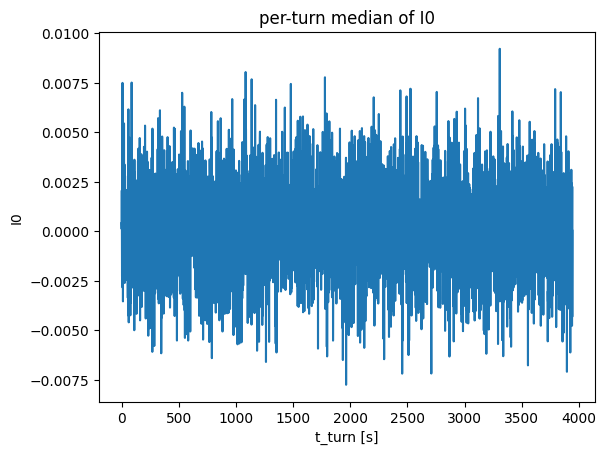

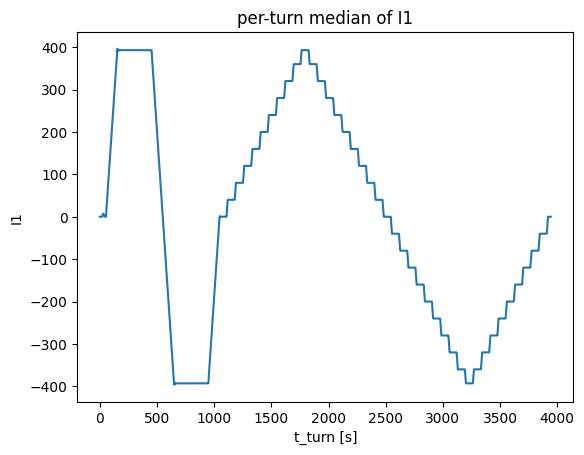

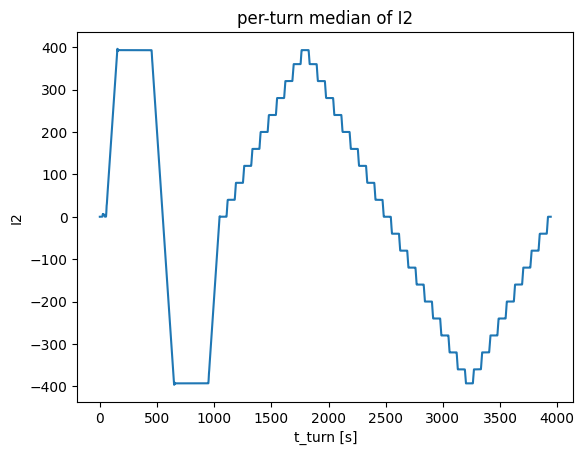

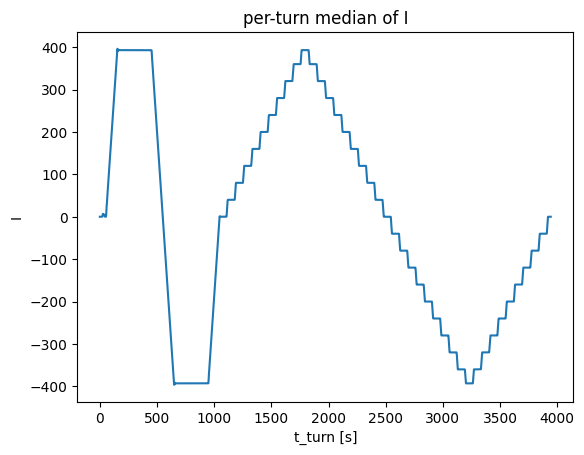

In [6]:
import numpy as np
import matplotlib.pyplot as plt

df = seg_frame.df
Ns = seg_frame.samples_per_turn
n_turns = len(df)//Ns

t_turn = df["t"].to_numpy()[0:n_turns*Ns:Ns]  # one timestamp per turn
for c in ["I0","I1","I2","I"]:
    if c in df.columns:
        x = df[c].to_numpy()[:n_turns*Ns].reshape(n_turns, Ns)
        plt.figure()
        plt.plot(t_turn, np.median(x, axis=1))
        plt.title(f"per-turn median of {c}")
        plt.xlabel("t_turn [s]")
        plt.ylabel(c)
        plt.show()


In [7]:
import numpy as np

df = seg_frame.df

# Sample-level correlation (often strong magnitude)
corr = np.corrcoef(df["df_abs"].to_numpy(), df["df_cmp"].to_numpy())[0,1]
print("corr(df_abs, df_cmp) =", corr)

# RMS ratio (cmp should be much smaller than abs)
rms_abs = np.sqrt(np.mean(df["df_abs"].to_numpy()**2))
rms_cmp = np.sqrt(np.mean(df["df_cmp"].to_numpy()**2))
print("rms_cmp/rms_abs =", rms_cmp/rms_abs)


corr(df_abs, df_cmp) = 0.1609099257182544
rms_cmp/rms_abs = 0.002975863618323114


In [8]:
I1 = df["I1"].to_numpy()
I2 = df["I2"].to_numpy()

print("corr(I1, I2) =", np.corrcoef(I1, I2)[0,1])
print("max|I1-I2| =", np.max(np.abs(I1 - I2)))
print("std(I1-I2) =", np.std(I1 - I2))


corr(I1, I2) = 1.0
max|I1-I2| = 0.0
std(I1-I2) = 0.0
